<h1 align="center"><b>Project Unit 03 - Losses Prediction</b></h1>
<h3 align="center"><b style="color:gray">XGBoost</b></h1>
<h3><b>Table of Contents</b></h3>
<ul style = "list-style-type: none; line-height: 0.5em;">
    <li><a href="#parameters"><h5>1. Project Parameters</h5></a></li>
    <li><a href="#data"><h5>2. Data Preprocessing</h5></a></li>
    <li><a href="#data"><h5>3. Data Analysis</h5></a></li>
    <li><a href="#data"><h5>4. Data Splitting</h5></a></li>
    <li><a href="#data"><h5>5. Models Training</h5></a></li>
    <li><a href="#data"><h5>6. Features Importance</h5></a></li>
    <li><a href="#data"><h5>7. Results</h5></a></li>
</ul>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from geopy.distance import geodesic
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, f1_score)
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, XGBRegressor
import time

# Parameters
n_closest_obs = 15
descriptive_stats = False
geodesic_distance = False

# POI - Kingston Hotel
x_poi = -76.7738135
y_poi = 17.9676456
losses_lb = 15000
losses_ub = 115000

## __2. Data Processing__

In [2]:
def calculate_enhanced_features(df_events, x_poi, y_poi):
    # 1. Proximity and intensity
    df_events["inverse_dist"] = 1 / (df_events["dist"] + 10e-9)
    df_events["mws_weighted"] = df_events["mws"] * df_events["inverse_dist"]
    df_events["mslp_weighted"] = df_events["mslp"] * df_events["inverse_dist"]
    # 2. Índices de severidad meteorológica
    df_events["pressure_deficit"] = 1013.25 - df_events["mslp"]  # Presión media a nivel del mar
    df_events["severity_index"] = (df_events["mws"] ** 2) / (df_events["dist"] + 1)
    df_events["risk_exposure"] = df_events["mws"] * df_events["pressure_deficit"] / (df_events["dist"] + 1)
    # 3. Size
    df_events["wind_pressure"] = 0.00256 * (df_events["mws"] ** 2)  # Presión dinámica del viento
    df_events["rmw_ratio"] = df_events["rmw"] / (df_events["mws"] + 0.1)  # Tamaño relativo del ojo
    # 4. Características de impacto compuesto
    df_events["compound_impact"] = df_events["severity_index"] * df_events["wind_pressure"]
    df_events["proximity_intensity"] = df_events["inverse_dist"] * df_events["mws"]
    return df_events

In [3]:
file_path = ".././data/elt_singleasset_KingstonHotel.csv"
df_losses = pd.read_csv(file_path)

# Target Variable
df_losses["is_payable"] = (df_losses["losses_total"] >= losses_lb).astype(int)
df_losses["is_full_payment"] = (df_losses["losses_total"] >= losses_ub).astype(int)
df_losses["class"] = df_losses["is_payable"] + df_losses["is_full_payment"]

df_events = pd.read_csv(".././data/stochastic_catalogue.csv")
df_events["dist"] = np.sqrt((df_events["x"] - x_poi)**2 + (df_events["y"] - y_poi)**2)

df_events = calculate_enhanced_features(df_events, x_poi, y_poi)

# Seleccionar n observaciones más cercanas por evento
df_events = df_events.sort_values(["code", "dist"])
df_events = df_events.groupby("code").head(n_closest_obs).reset_index(drop=True)

df_events["obs"] = df_events.groupby("code").cumcount() + 1
df_pivoted = df_events.pivot_table(
    index="code", 
    columns="obs", 
    values=["dist", "mslp", "mws", "rmw", 
            "inverse_dist", "mws_weighted", "mslp_weighted",
            "pressure_deficit", "severity_index", "risk_exposure",
            "wind_pressure", "rmw_ratio", "compound_impact", "proximity_intensity"], 
    aggfunc="first"
)


df_pivoted.columns = [f"{col[0]}_r{col[1]}" for col in df_pivoted.columns]
df_pivoted = df_pivoted.reset_index()
dist_cols = [col for col in df_pivoted.columns if col.startswith("dist")]
other_cols = [col for col in df_pivoted.columns if col not in dist_cols]
df_filled = df_pivoted[dist_cols].ffill(axis=1)
mask = df_pivoted[dist_cols].isna()
df_pivoted[dist_cols] = df_pivoted[dist_cols].fillna(df_filled * 2)
df_pivoted[other_cols] = df_pivoted[other_cols].ffill(axis=1)


df_merged = pd.merge(
    df_pivoted, 
    df_losses[["event_name", "losses_total", "class"]], 
    left_on="code", 
    right_on="event_name", 
    how="left"
)

df_merged["losses_total"] = df_merged["losses_total"].fillna(0)
df_merged["class"] = df_merged["class"].fillna(0).astype(int)
df_merged = df_merged.drop(columns=["event_name"])
df_merged = df_merged.fillna(0)

enhanced_data = df_merged.copy()

## __3. Data Analysis__

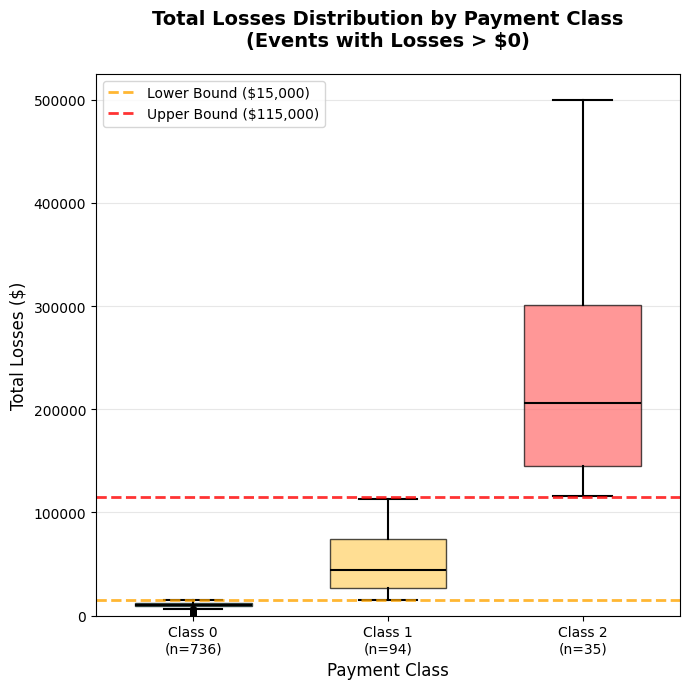

In [4]:
plt.figure(figsize=(7, 7))

df_losses_positive = enhanced_data[enhanced_data["losses_total"] > 0]
boxplot_data = []
class_labels_box = []
colors_box = ["#06d6a0", "#ffd166", "#ff6b6b"]

for class_val in [0, 1, 2]:
    class_data = df_losses_positive[df_losses_positive["class"] == class_val]["losses_total"]
    if len(class_data) > 0:
        boxplot_data.append(class_data)
        class_labels_box.append(f"Class {class_val}\n(n={len(class_data)})")


box = plt.boxplot(boxplot_data, tick_labels=class_labels_box, patch_artist=True, 
                  widths=0.6, showfliers=True)
for patch, color in zip(box["boxes"], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
for element in ["whiskers", "caps", "medians"]:
    for line in box[element]:
        line.set_color("black")
        line.set_linewidth(1.5)
for flier in box["fliers"]:
    flier.set(marker="o", color="red", alpha=0.5, markersize=4)

# Add reference lines
plt.axhline(y=losses_lb, color="orange", linestyle="--", linewidth=2, 
            label=f"Lower Bound (${losses_lb:,})", alpha=0.8)
plt.axhline(y=losses_ub, color="red", linestyle="--", linewidth=2, 
            label=f"Upper Bound (${losses_ub:,})", alpha=0.8)


plt.title("Total Losses Distribution by Payment Class\n(Events with Losses > $0)", 
          fontsize=14, fontweight="bold", pad=20)
plt.ylabel("Total Losses ($)", fontsize=12)
plt.xlabel("Payment Class", fontsize=12)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.ylim(bottom=0)

plt.tight_layout()
plt.savefig("./figures/losses_distribution.png")
plt.show()

In [5]:
total_events = len(enhanced_data)
events_with_losses = len(enhanced_data[enhanced_data["losses_total"] > 0])

print(f"\nOVERVIEW:")
print(f"Total events analyzed: {total_events:,}")
print(f"Events with positive losses: {events_with_losses:,} ({events_with_losses/total_events*100:.2f}%)")
print(f"Payment thresholds: Lower = ${losses_lb:,}, Upper = ${losses_ub:,}")

for class_val, class_name in zip([0, 1, 2], ["NON-PAYABLE", "PARTIALLY PAYABLE", "FULLY PAYABLE"]):
    class_data = enhanced_data[enhanced_data["class"] == class_val]
    class_positive = class_data[class_data["losses_total"] > 0]
    print(f"\n{class_name} (Class {class_val}):")
    print(f"  - Total events: {len(class_data):,} ({len(class_data)/total_events*100:.2f}%)")
    print(f"  - Events with losses > $0: {len(class_positive):,}")
    if len(class_positive) > 0:
        loss_stats = class_positive["losses_total"].describe()
        print(f"  - Loss statistics for events with positive losses:")
        print(f"      + Average loss: ${loss_stats['mean']:,.2f}")
        print(f"      + Minimum loss: ${loss_stats['min']:,.2f}")
        print(f"      + Maximum loss: ${loss_stats['max']:,.2f}")
        print(f"      + Median loss: ${loss_stats['50%']:,.2f}")
        print(f"      + Standard deviation: ${loss_stats['std']:,.2f}")


OVERVIEW:
Total events analyzed: 143,490
Events with positive losses: 865 (0.60%)
Payment thresholds: Lower = $15,000, Upper = $115,000

NON-PAYABLE (Class 0):
  - Total events: 143,361 (99.91%)
  - Events with losses > $0: 736
  - Loss statistics for events with positive losses:
      + Average loss: $10,330.05
      + Minimum loss: $7.20
      + Maximum loss: $14,930.80
      + Median loss: $10,496.25
      + Standard deviation: $2,597.51

PARTIALLY PAYABLE (Class 1):
  - Total events: 94 (0.07%)
  - Events with losses > $0: 94
  - Loss statistics for events with positive losses:
      + Average loss: $51,383.79
      + Minimum loss: $15,327.00
      + Maximum loss: $112,655.60
      + Median loss: $44,303.10
      + Standard deviation: $28,904.42

FULLY PAYABLE (Class 2):
  - Total events: 35 (0.02%)
  - Events with losses > $0: 35
  - Loss statistics for events with positive losses:
      + Average loss: $237,933.73
      + Minimum loss: $115,835.20
      + Maximum loss: $500,087.

In [6]:
key_variables = ["severity_index_r1", "risk_exposure_r1", "compound_impact_r1", "proximity_intensity_r1"]
if all(var in enhanced_data.columns for var in key_variables):
    for var in key_variables:
        if var in enhanced_data.columns:
            stats = enhanced_data[var].describe()
            print(f"\n{var}:")
            print(f"  - Media: {stats['mean']:.4f}")
            print(f"  - Std: {stats['std']:.4f}")
            print(f"  - Min: {stats['min']:.4f}")
            print(f"  - Max: {stats['max']:.4f}")


severity_index_r1:
  - Media: 365.2370
  - Std: 855.6026
  - Min: 12.0554
  - Max: 21676.2180

risk_exposure_r1:
  - Media: 166.6472
  - Std: 538.4673
  - Min: -144.3596
  - Max: 14836.2817

compound_impact_r1:
  - Media: 8030.7382
  - Std: 36591.8354
  - Min: 22.4983
  - Max: 1616295.4091

proximity_intensity_r1:
  - Media: 9.0314
  - Std: 53.8837
  - Min: 0.4540
  - Max: 14894.1186


## __4. Data Splitting__

In [7]:
X = enhanced_data.drop(["class", "losses_total"], axis=1)
y_cat = enhanced_data["class"]
y_losses = enhanced_data["losses_total"]

# Classifier
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y_cat, test_size=0.3, random_state=42, stratify=y_cat
)
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(
    X_train_cat, y_train_cat, test_size=0.2, random_state=42, stratify=y_train_cat
)

# Regression
X_train_losses, X_test_losses, y_train_losses, y_test_losses = train_test_split(
    X, y_losses, test_size=0.3, random_state=42
)
X_train_losses, X_val_losses, y_train_losses, y_val_losses = train_test_split(
    X_train_losses, y_train_losses, test_size=0.2, random_state=42
)

print(f"Training dataset: {y_train_cat.shape[0]:,} samples")
print(f"Validation dataset: {X_test_cat.shape[0]:,} samples")
print(f"Test dataset: {X_val_cat.shape[0]:,} samples")

Training dataset: 80,354 samples
Validation dataset: 43,047 samples
Test dataset: 20,089 samples


## __5. Models Training__

In [8]:
class_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4, 
    objective="multi:softprob",
    eval_metric="mlogloss",
    reg_alpha=0.5,
    reg_lambda=2.0,
    gamma=0.2,
    subsample=0.7,
    colsample_bytree=0.7,
    early_stopping_rounds=50,
    random_state=42,
)

t0 = time.time()
class_model.fit(
    X_train_cat, y_train_cat,
    eval_set = [(X_train_cat, y_train_cat), (X_val_cat, y_val_cat)],
    verbose  = 10
)
print(f"Training time: {time.time() - t0:.4f} s")

[0]	validation_0-mlogloss:0.52176	validation_1-mlogloss:0.52177
[10]	validation_0-mlogloss:0.29903	validation_1-mlogloss:0.29925
[20]	validation_0-mlogloss:0.17604	validation_1-mlogloss:0.17642
[30]	validation_0-mlogloss:0.10519	validation_1-mlogloss:0.10570
[40]	validation_0-mlogloss:0.06345	validation_1-mlogloss:0.06407
[50]	validation_0-mlogloss:0.03854	validation_1-mlogloss:0.03926
[60]	validation_0-mlogloss:0.02356	validation_1-mlogloss:0.02438
[70]	validation_0-mlogloss:0.01451	validation_1-mlogloss:0.01541
[80]	validation_0-mlogloss:0.00902	validation_1-mlogloss:0.01000
[90]	validation_0-mlogloss:0.00569	validation_1-mlogloss:0.00671
[100]	validation_0-mlogloss:0.00365	validation_1-mlogloss:0.00473
[110]	validation_0-mlogloss:0.00239	validation_1-mlogloss:0.00355
[120]	validation_0-mlogloss:0.00162	validation_1-mlogloss:0.00285
[130]	validation_0-mlogloss:0.00114	validation_1-mlogloss:0.00242
[140]	validation_0-mlogloss:0.00084	validation_1-mlogloss:0.00216
[150]	validation_0-ml

In [9]:
reg_model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=4,
    objective="reg:squarederror",
    eval_metric="mae", 
    reg_alpha=0.5,
    reg_lambda=2.0,
    gamma=0.2,
    subsample=0.7,
    colsample_bytree=0.7,
    early_stopping_rounds=50,
    random_state=42
)

t0 = time.time()
reg_model.fit(
    X_train_losses, y_train_losses,
    eval_set = [(X_train_losses, y_train_losses), (X_val_losses, y_val_losses)],
    verbose  = 10
)
print(f"Training time: {time.time() - t0:.4f} s")

[0]	validation_0-mae:292.74199	validation_1-mae:264.72926
[10]	validation_0-mae:272.77485	validation_1-mae:246.84456
[20]	validation_0-mae:254.40530	validation_1-mae:231.46266
[30]	validation_0-mae:237.64910	validation_1-mae:217.00774
[40]	validation_0-mae:222.59042	validation_1-mae:204.38466
[50]	validation_0-mae:209.23442	validation_1-mae:193.92253
[60]	validation_0-mae:196.96604	validation_1-mae:184.32453
[70]	validation_0-mae:185.80663	validation_1-mae:175.55949
[80]	validation_0-mae:175.38644	validation_1-mae:167.39563
[90]	validation_0-mae:166.11239	validation_1-mae:159.95203
[100]	validation_0-mae:157.78135	validation_1-mae:153.53374
[110]	validation_0-mae:150.57644	validation_1-mae:148.11071
[120]	validation_0-mae:143.80202	validation_1-mae:143.82646
[130]	validation_0-mae:137.59251	validation_1-mae:139.80850
[140]	validation_0-mae:131.83572	validation_1-mae:136.43269
[150]	validation_0-mae:126.34331	validation_1-mae:133.36474
[160]	validation_0-mae:121.64209	validation_1-mae:1

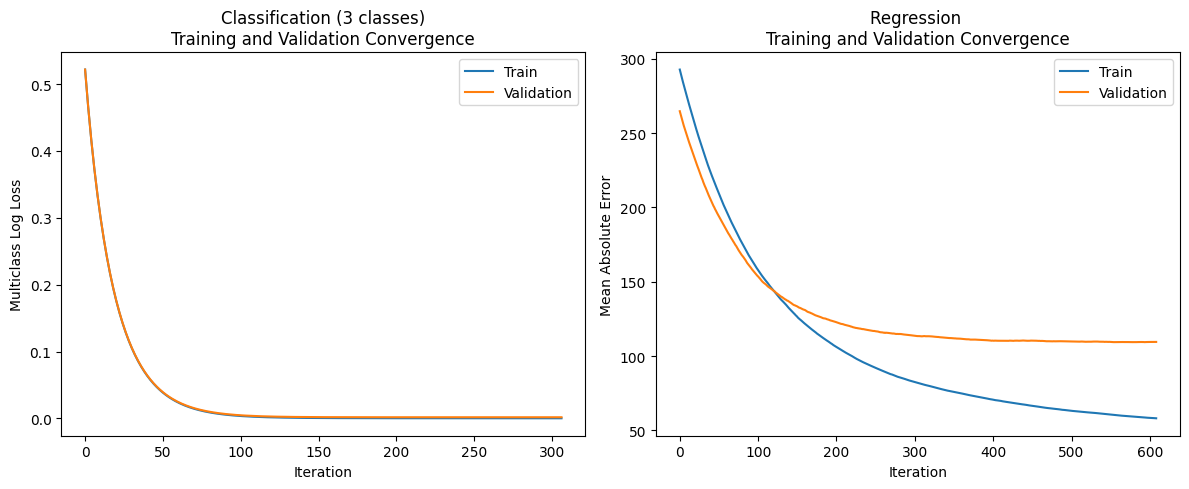

In [10]:
evals_result_cat = class_model.evals_result()
evals_result_losses = reg_model.evals_result()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

epochs = len(evals_result_cat["validation_0"]["mlogloss"])
x_axis = range(0, epochs)
axs[0].plot(x_axis, evals_result_cat["validation_0"]["mlogloss"], label="Train")
axs[0].plot(x_axis, evals_result_cat["validation_1"]["mlogloss"], label="Validation")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Multiclass Log Loss")
axs[0].set_title("Classification (3 classes)\nTraining and Validation Convergence")
axs[0].legend()

epochs = len(evals_result_losses["validation_0"]["mae"])
x_axis = range(0, epochs)
axs[1].plot(x_axis, evals_result_losses["validation_0"]["mae"], label="Train")
axs[1].plot(x_axis, evals_result_losses["validation_1"]["mae"], label="Validation")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Mean Absolute Error")
axs[1].set_title("Regression \nTraining and Validation Convergence")
axs[1].legend()

plt.tight_layout()
plt.savefig("./figures/losses_convergence.png")
plt.show()

## __6. Features Importance__

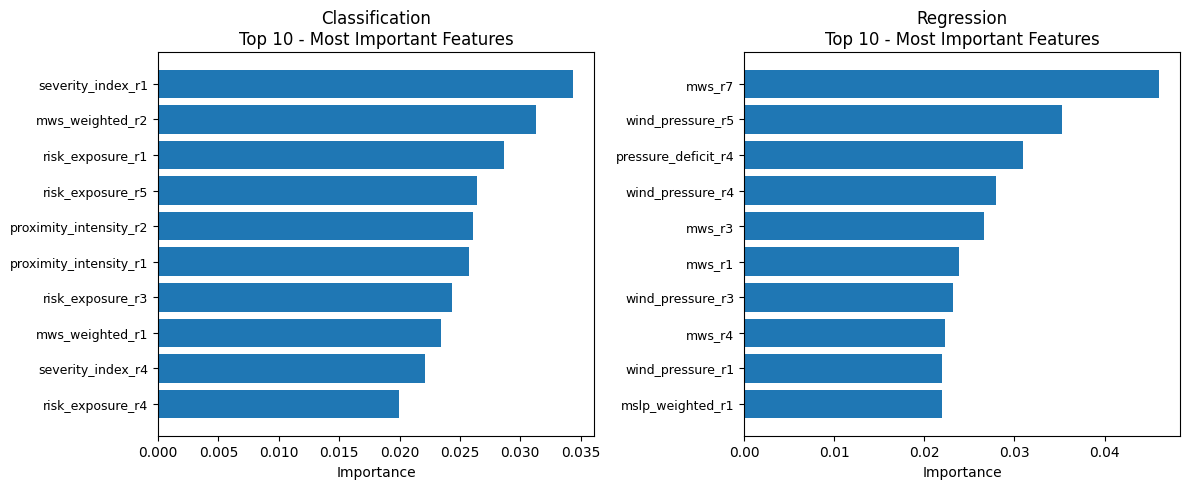

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

feature_importance = class_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
sorted_features = [X.columns[i] for i in sorted_idx]
sorted_importance = feature_importance[sorted_idx]
axs[0].barh(range(len(sorted_idx)), sorted_importance)
axs[0].set_yticks(range(len(sorted_idx)))
axs[0].set_yticks(range(len(sorted_idx)), sorted_features, fontsize=9)
axs[0].set_title("Classification\nTop 10 - Most Important Features")
axs[0].set_xlabel("Importance")

feature_importance = reg_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
sorted_features = [X.columns[i] for i in sorted_idx]
sorted_importance = feature_importance[sorted_idx]
axs[1].barh(range(len(sorted_idx)), sorted_importance)
axs[1].set_yticks(range(len(sorted_idx)))
axs[1].set_yticks(range(len(sorted_idx)), sorted_features, fontsize=9)
axs[1].set_title("Regression\nTop 10 - Most Important Features")
axs[1].set_xlabel("Importance")

plt.tight_layout()
plt.savefig("./figures/losses_features.png")
plt.show()

## __7. Results__

F1 Score (Weighted) - Training: 1.0000
F1 Score (Weighted) - Test: 0.9990
F1 Score (Macro) - Training: 0.9883
F1 Score (Macro) - Test: 0.5168

Per-class F1 Scores (Test):
  Non-Payable (0): 0.9997
  Partially Payable (1): 0.2174
  Fully Payable (2): 0.3333


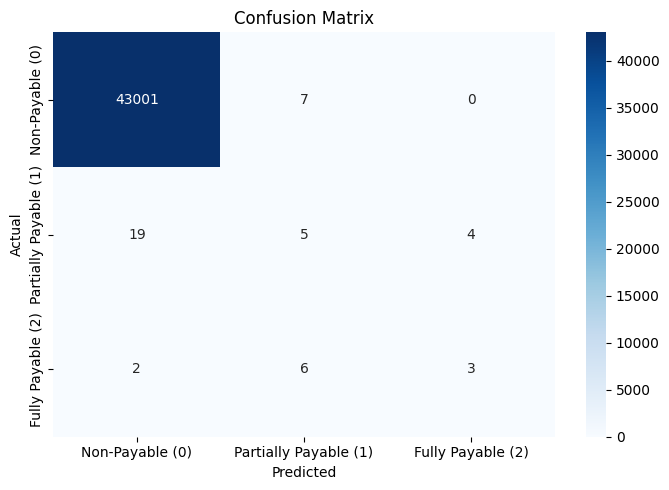

In [12]:
y_pred_train = class_model.predict(X_train_cat)
y_pred_test = class_model.predict(X_test_cat)
y_pred_proba_test = class_model.predict_proba(X_test_cat)


train_f1 = f1_score(y_train_cat, y_pred_train, average="weighted")
test_f1 = f1_score(y_test_cat, y_pred_test, average="weighted")
train_f1_macro = f1_score(y_train_cat, y_pred_train, average="macro")
test_f1_macro = f1_score(y_test_cat, y_pred_test, average="macro")
f1_per_class = f1_score(y_test_cat, y_pred_test, average=None)


print(f"F1 Score (Weighted) - Training: {train_f1:.4f}")
print(f"F1 Score (Weighted) - Test: {test_f1:.4f}")
print(f"F1 Score (Macro) - Training: {train_f1_macro:.4f}")
print(f"F1 Score (Macro) - Test: {test_f1_macro:.4f}")
print("\nPer-class F1 Scores (Test):")
class_names = ["Non-Payable (0)", "Partially Payable (1)", "Fully Payable (2)"]
for i, (f1, class_name) in enumerate(zip(f1_per_class, class_names)):
    print(f"  {class_name}: {f1:.4f}")


plt.figure(figsize=(7, 5))

cm = confusion_matrix(y_test_cat, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.savefig("./figures/losses_confusion_matrix.png")
plt.show()

MAE (Mean Absolute Error):
  Training: $60.15
  Validation: $109.35
  Test: $106.94

RMSE (Root Mean Squared Error):
  Training: $884.41
  Validation: $2,403.17
  Test: $2,826.14


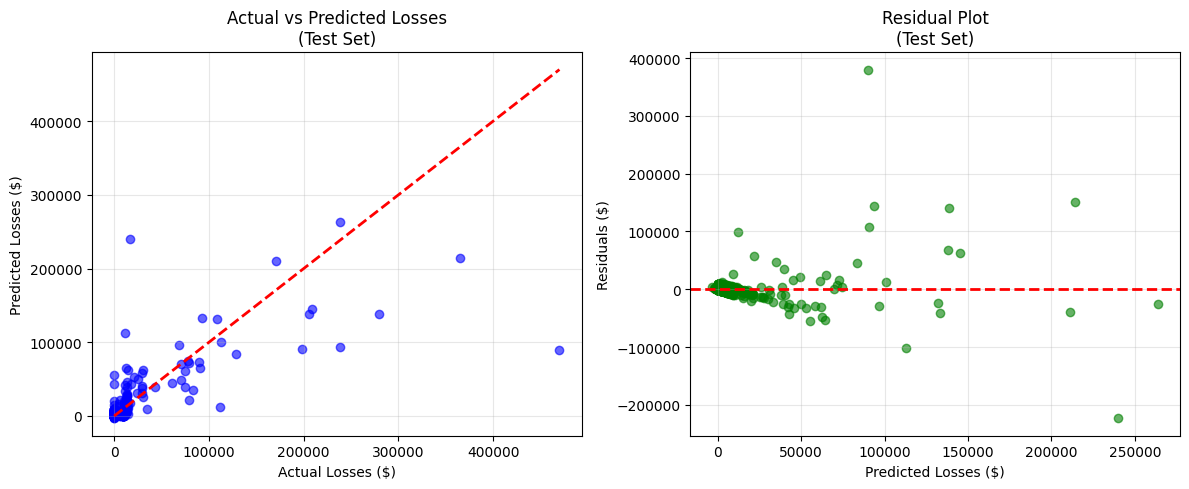

In [13]:
y_pred_train_reg = reg_model.predict(X_train_losses)
y_pred_val_reg = reg_model.predict(X_val_losses)
y_pred_test_reg = reg_model.predict(X_test_losses)


train_mae = mean_absolute_error(y_train_losses, y_pred_train_reg)
val_mae = mean_absolute_error(y_val_losses, y_pred_val_reg)
test_mae = mean_absolute_error(y_test_losses, y_pred_test_reg)
train_rmse = np.sqrt(mean_squared_error(y_train_losses, y_pred_train_reg))
val_rmse = np.sqrt(mean_squared_error(y_val_losses, y_pred_val_reg))
test_rmse = np.sqrt(mean_squared_error(y_test_losses, y_pred_test_reg))


print("MAE (Mean Absolute Error):")
print(f"  Training: ${train_mae:,.2f}")
print(f"  Validation: ${val_mae:,.2f}")
print(f"  Test: ${test_mae:,.2f}")
print("\nRMSE (Root Mean Squared Error):")
print(f"  Training: ${train_rmse:,.2f}")
print(f"  Validation: ${val_rmse:,.2f}")
print(f"  Test: ${test_rmse:,.2f}")


# Visualization for regressor
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Actual vs Predicted (Test set)
axs[0].scatter(y_test_losses, y_pred_test_reg, alpha=0.6, color="blue")
axs[0].plot([y_test_losses.min(), y_test_losses.max()], 
           [y_test_losses.min(), y_test_losses.max()], "r--", lw=2)
axs[0].set_xlabel("Actual Losses ($)")
axs[0].set_ylabel("Predicted Losses ($)")
axs[0].set_title("Actual vs Predicted Losses\n(Test Set)")
axs[0].grid(True, alpha=0.3)

# Plot 2: Residuals plot
residuals = y_test_losses - y_pred_test_reg
axs[1].scatter(y_pred_test_reg, residuals, alpha=0.6, color="green")
axs[1].axhline(y=0, color="r", linestyle="--", linewidth=2)
axs[1].set_xlabel("Predicted Losses ($)")
axs[1].set_ylabel("Residuals ($)")
axs[1].set_title("Residual Plot\n(Test Set)")
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/losses_regression.png")
plt.show()